In [90]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [330]:
df = pd.read_csv('nacas.csv')
df.head(n=5)

,naca,reynolds,alpha,CL,CD,CDp,CM,Top_Xtr,Bot_Xtr
0,0006,100000,-10.00,-0.5661,0.11269,0.10814,0.0140,1.0,0.0914
1,0006,100000,-9.75,-0.5830,0.10909,0.10461,0.0097,1.0,0.0925
2,0006,100000,-9.50,-0.7037,0.11447,0.10977,0.0241,1.0,0.0814
3,0006,100000,-9.25,-0.6934,0.11087,0.10614,0.0257,1.0,0.0859
4,0006,100000,-9.00,-0.6952,0.10675,0.10207,0.0227,1.0,0.0898


In [274]:
def printnaca(naca):
    X=[]
    Y=[]
    file = open(f'Coords/naca{naca}.dat')
    for line in file:
        if 'N' in line:
            for line in file:
                elem = line.split(' ')
                X.append(float(elem[0]))
                Y.append(float(elem[-1][:-2]))
    plt.plot(X,Y)
    

In [302]:
L = list(np.unique(list(df['naca'])))
L = list(filter(lambda x: len(x) == 4, L))
L

['0006',
 '0008',
 '0010',
 '0015',
 '0018',
 '0021',
 '0024',
 '1408',
 '1410',
 '1412',
 '2408',
 '2410',
 '2411',
 '2412',
 '2415',
 '2418',
 '2421',
 '2424',
 '4412',
 '4415',
 '4418',
 '4421',
 '4424',
 '6412']

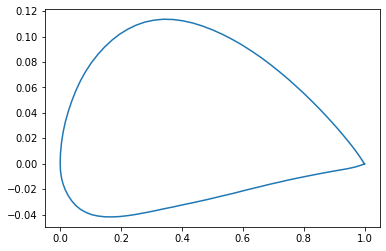

In [323]:
printnaca('4415')

In [371]:
# Vrillage de test : pour un rayon de 5cm va de pi/2 (90°) à 0 (0°)

def f_1(x):
    return (x-0.01)/(0.1-0.01) * 0.1 + (x-0.1)/(0.01-0.1) * 12

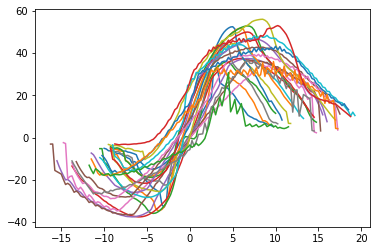

In [316]:
for naca in L:
    sub = df.loc[(df['naca'] == naca) & (df['reynolds'] == 100000)]
    plt.plot(sub['alpha'],sub['CL']/sub['CD'])

In [311]:
finesse_max = []
for naca in L:
    sub = df.loc[(df['naca'] == naca) & (df['reynolds'] == 100000)]
    finesse = list(sub['CL']/sub['CD'])
    fin_max = np.max(finesse)
    finesse_max.append(fin_max)
finesse_max = np.array(finesse_max)

In [320]:
arr = finesse_max.argsort()[-10:]

([<matplotlib.axis.YTick at 0x2f4cad6acc8>,
 <a list of 22 Text yticklabel objects>)

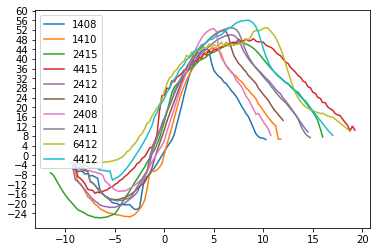

In [326]:
for k in arr:
    sub = df.loc[(df['naca'] == L[k]) & (df['reynolds'] == 100000)]
    plt.plot(sub['alpha'],sub['CL']/sub['CD'], label = L[k])
plt.legend()
plt.yticks([60/15*k for k in range(-6,16)])

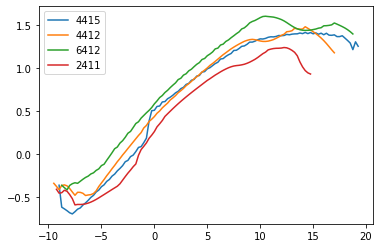

In [328]:
selected = ['4415','4412','6412','2411']
for naca in selected:
    sub = df.loc[(df['naca'] == naca) & (df['reynolds'] == 100000)]
    plt.plot(sub['alpha'],sub['CL'], label = naca)
plt.legend()

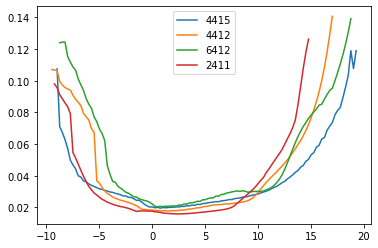

In [329]:
selected = ['4415','4412','6412','2411']
for naca in selected:
    sub = df.loc[(df['naca'] == naca) & (df['reynolds'] == 100000)]
    plt.plot(sub['alpha'],sub['CD'], label = naca)
plt.legend()

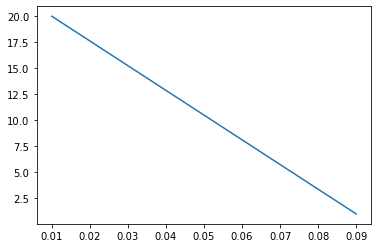

In [204]:
X = np.arange(1/100,10/100,1/100)
plt.plot(X,f_1(X))

In [186]:
def NN(element, L):
    l = len(L)
    cand = 0
    tol = np.abs(L[0])+np.abs(element)
    for k in range(l):
        if np.abs(L[k]-element)<tol:
            cand = k
            tol = np.abs(L[k]-element)
    return cand

In [399]:
def larg(r):
    if 0.01<=r<=0.05:
        return (r-0.01)/(0.05-0.01) * 0.02 + (r-0.05)/(0.01-0.05) * 0.007
    if 0.05<r:
        return (r-0.05)/(0.1 - 0.05) * 0.007 + (r-0.1)/(0.05-0.1) * 0.02

In [375]:
np.arange(0.11,1/10)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

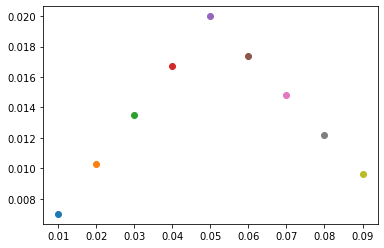

In [400]:
for k in np.arange(0.01,0.1,1/100):
    plt.plot(k,larg(k),"o")

In [410]:
def drag_lift(naca, rayon_min, rayon_max, f_vrillage, tpm, v_vertical, largeur, pas = 5):
    portances = []
    pho_air = 1.2
    lift_tot = 0
    drag_tot = 0
    mu_air = 1.56*10**-5
    RAYONS = np.arange(rayon_min, rayon_max, (rayon_max-rayon_min)/pas)

    for rayon in RAYONS:
        vitesse_rot = 2 * np.pi * tpm/60 * rayon
        rey = np.sqrt(v_vertical**2+vitesse_rot**2)*(rayon_max-rayon_min)/(mu_air)

        all_rey = df.loc[df['naca'] == naca]['reynolds']
        reynolds = list(all_rey)[NN(rey, list(all_rey))]
        vrillage = f_vrillage(rayon)

        alpha = vrillage - np.arctan(v_vertical/vitesse_rot)/np.pi*180

        sub_df = df.loc[(df['naca'] == naca) & (df['reynolds'] == reynolds)]

        index = NN(alpha, list(sub_df['alpha']))
        print(list(sub_df['alpha'])[index])

        CD = list(sub_df['CD'])[index]
        CL = list(sub_df['CL'])[index]

        local_larg = largeur(rayon)

        lift_tot+= 1/2 * pho_air * (v_vertical**2+vitesse_rot**2) * local_larg * (RAYONS[2]-RAYONS[1]) * CL
        drag_tot+= 1/2 * pho_air * (v_vertical**2+vitesse_rot**2) * local_larg * (RAYONS[2]-RAYONS[1]) * CD
        portances.append(lift_tot)

    return lift_tot, drag_tot, portances

In [411]:
L,D, al = drag_lift(naca = '6412', rayon_min = 1/100, rayon_max = 10/100, f_vrillage = f_1, tpm = 6000, v_vertical = 0, largeur = larg, pas = 10)

10.5
10.5
9.5
8.5
7.25
6.0
4.75
3.75
2.5
1.25


In [408]:
L*8

8.041801860284233

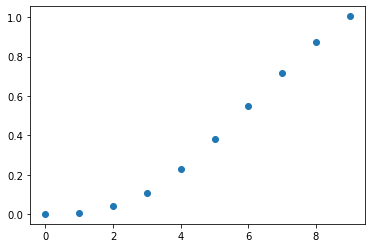

In [409]:
plt.plot(al,'o')

In [134]:
index = NN(a,b)

In [42]:
 x = drag_lift(1,0,10,0,0,0)